In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
%cd /content/drive/MyDrive/Universidad/Aprendizaje Automático II/Práctica/Trabajos/FINAL/IMAGENES

/content/drive/MyDrive/AA II/NUEVO (1)


In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Definir transformaciones para los datos de entrenamiento y validación
transformaciones = transforms.Compose([
    transforms.Resize((100, 100)),  # Redimensionar las imágenes
    transforms.ToTensor()  # Convertir las imágenes a tensores
])

# Cargar los datos de entrenamiento y validación
dataset_entrenamiento = ImageFolder(root='/Users/alejandroalemanaleman/Downloads/AA2 - trabajo 1/train_augmented', transform=transformaciones)
dataset_validacion = ImageFolder(root='/Users/alejandroalemanaleman/Downloads/AA2 - trabajo 1/validation', transform=transformaciones)
dataset_test = ImageFolder(root='/Users/alejandroalemanaleman/Downloads/AA2 - trabajo 1/test', transform=transformaciones)

In [3]:
import copy

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # Capas convolucionales
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Nueva capa convolucional

        # Batch Normalization para cada capa convolucional
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.bn4 = nn.BatchNorm2d(num_features=128)  # Normalización para la nueva capa

        # MaxPooling y Dropout
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout_conv = nn.Dropout(p=0.25)  # Dropout para capas convolucionales
        self.dropout_fc = nn.Dropout(p=0.5)  # Dropout para capas densas

        # Capas completamente conectadas
        self.fc1 = nn.Linear(128 * 6 * 6, 256)  # Ajuste del tamaño según salida de la última capa convolucional
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 7)  # Salida para 7 clases

        # Batch Normalization para capas densas
        self.fc_bn1 = nn.BatchNorm1d(256)
        self.fc_bn2 = nn.BatchNorm1d(128)

    def forward(self, x):
        # Pasos convolucionales con activación, normalización y pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout_conv(x)

        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout_conv(x)

        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout_conv(x)

        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # Nueva capa convolucional
        x = self.dropout_conv(x)

        # Aplanar para pasar a capas densas
        x = x.view(-1, 128 * 6 * 6)

        # Pasos densos con activación, normalización y dropout
        x = F.relu(self.fc_bn1(self.fc1(x)))
        x = self.dropout_fc(x)

        x = F.relu(self.fc_bn2(self.fc2(x)))
        x = self.dropout_fc(x)

        x = self.fc3(x)  # Sin activación final porque CrossEntropyLoss la incluye
        return x


In [5]:
def graficar_perdida_entrenamiento_validacion(lr, batch_size, epochs, valores_perdida, exactitud_entrenamiento, exactitud_validacion):
    # Crear una figura con dos subgráficos en una fila
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Graficar la función de pérdida en el primer subgráfico
    ax[0].plot(valores_perdida, label='Pérdida')
    ax[0].set_xlabel('Épocas')
    ax[0].set_ylabel('Pérdida')
    ax[0].set_title(f'Función de Pérdida\n LR: {lr} Batch Size: {batch_size}')
    ax[0].legend()

    # Graficar las exactitudes en el segundo subgráfico
    ax[1].plot(exactitud_entrenamiento, label='Exactitud de Entrenamiento')
    ax[1].plot(exactitud_validacion, label='Exactitud de Validación')
    ax[1].set_xlabel('Épocas')
    ax[1].set_ylabel('Exactitud')
    ax[1].set_title(f'Exactitud de Entrenamiento y Validación\n LR: {lr} Batch Size: {batch_size}')
    ax[1].legend()

    # Ajustar espaciado entre los gráficos
    plt.tight_layout()

    # Mostrar los gráficos
    plt.show()

In [6]:
def calcular_exactitud_test(modelo, dataloader_test, device):
    correctas = 0
    total = 0
    with torch.no_grad():
        modelo.eval()

        for images, labels in dataloader_test:
            images, labels = images.to(device), labels.to(device)
            outputs = modelo(images)
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correctas += (predicted == labels).sum().item()
        #print(f'Exactitud de el modelo con las {total} imágenes de test: {100*correctas/total}%')
    return 100*correctas/total

In [7]:
def matriz_de_confusion(modelo, dataloader_test, device):

    modelo.eval()

    # Inicializar listas para etiquetas reales y predicciones
    predicciones_totales = []
    etiquetas_reales_totales = []

    # Verificar que el dataloader_test tiene datos
    if len(dataloader_test.dataset) == 0:
        print("El conjunto de test está vacío. Verifica los datos.")
    else:
        # Bucle para obtener predicciones
        with torch.no_grad():
            for imagenes, etiquetas in dataloader_test:
                imagenes, etiquetas = imagenes.to(device), etiquetas.to(device)
                salidas = modelo(imagenes)
                _, predicciones = torch.max(salidas, 1)
                predicciones_totales.extend(predicciones.cpu().numpy())
                etiquetas_reales_totales.extend(etiquetas.cpu().numpy())

    # Comprobar si se obtuvieron predicciones
    if len(etiquetas_reales_totales) > 0 and len(predicciones_totales) > 0:
        # Imprimir el reporte de clasificación
        print("Reporte de clasificación:")
        print(classification_report(etiquetas_reales_totales, predicciones_totales, digits=4))

        # Crear la matriz de confusión
        etiquetas_unicas = sorted(set(etiquetas_reales_totales))  # Identificar las clases presentes
        matriz_confusion_test = confusion_matrix(etiquetas_reales_totales, predicciones_totales, labels=etiquetas_unicas)

        # Visualizar la matriz de confusión
        plt.figure(figsize=(10, 8))
        sns.heatmap(matriz_confusion_test, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas_unicas, yticklabels=etiquetas_unicas)
        plt.xlabel('Predicciones')
        plt.ylabel('Etiquetas Reales')
        plt.title('Matriz de Confusión del Conjunto de Test')
        plt.show()

        # Mostrar las clases presentes
        clases_presentes = set(etiquetas_reales_totales)
        print(f"Clases presentes en el conjunto de test: {clases_presentes}")
    else:
        print("No se encontraron datos válidos para generar predicciones o etiquetas.")


Entrenando con lr=0.005, batch_size=32, epochs=15
    Época 1, pérdida: 1.5616, exactitud entrenamiento: 45.78%, exactitud validación: 45.69%
Learning rate actual: 0.005000
    Época 2, pérdida: 1.2289, exactitud entrenamiento: 25.80%, exactitud validación: 27.98%
Learning rate actual: 0.005000
    Época 3, pérdida: 1.0748, exactitud entrenamiento: 54.61%, exactitud validación: 60.18%
Learning rate actual: 0.005000
    Época 4, pérdida: 0.9200, exactitud entrenamiento: 78.90%, exactitud validación: 76.70%
Learning rate actual: 0.005000
    Época 5, pérdida: 0.8316, exactitud entrenamiento: 79.31%, exactitud validación: 76.51%
Learning rate actual: 0.005000
    Época 6, pérdida: 0.7388, exactitud entrenamiento: 81.16%, exactitud validación: 79.08%
Learning rate actual: 0.005000
    Época 7, pérdida: 0.6705, exactitud entrenamiento: 84.89%, exactitud validación: 80.55%
Learning rate actual: 0.005000
    Época 8, pérdida: 0.6176, exactitud entrenamiento: 86.86%, exactitud validación: 82.

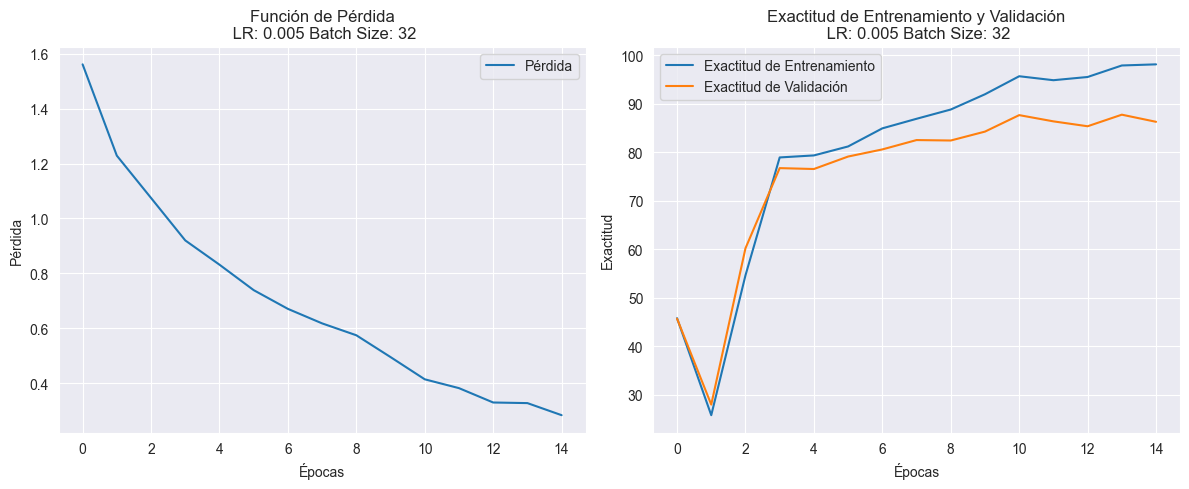


Entrenando con lr=0.005, batch_size=32, epochs=30
    Época 1, pérdida: 1.5230, exactitud entrenamiento: 56.32%, exactitud validación: 59.45%
Learning rate actual: 0.005000
    Época 2, pérdida: 1.2118, exactitud entrenamiento: 63.82%, exactitud validación: 66.51%
Learning rate actual: 0.005000
    Época 3, pérdida: 1.0565, exactitud entrenamiento: 70.12%, exactitud validación: 69.54%
Learning rate actual: 0.005000
    Época 4, pérdida: 0.9325, exactitud entrenamiento: 73.58%, exactitud validación: 71.65%
Learning rate actual: 0.005000
    Época 5, pérdida: 0.8241, exactitud entrenamiento: 76.73%, exactitud validación: 75.50%
Learning rate actual: 0.005000
    Época 6, pérdida: 0.7438, exactitud entrenamiento: 83.61%, exactitud validación: 80.18%
Learning rate actual: 0.005000
    Época 7, pérdida: 0.6708, exactitud entrenamiento: 81.82%, exactitud validación: 79.45%
Learning rate actual: 0.005000
    Época 8, pérdida: 0.6012, exactitud entrenamiento: 84.20%, exactitud validación: 81.

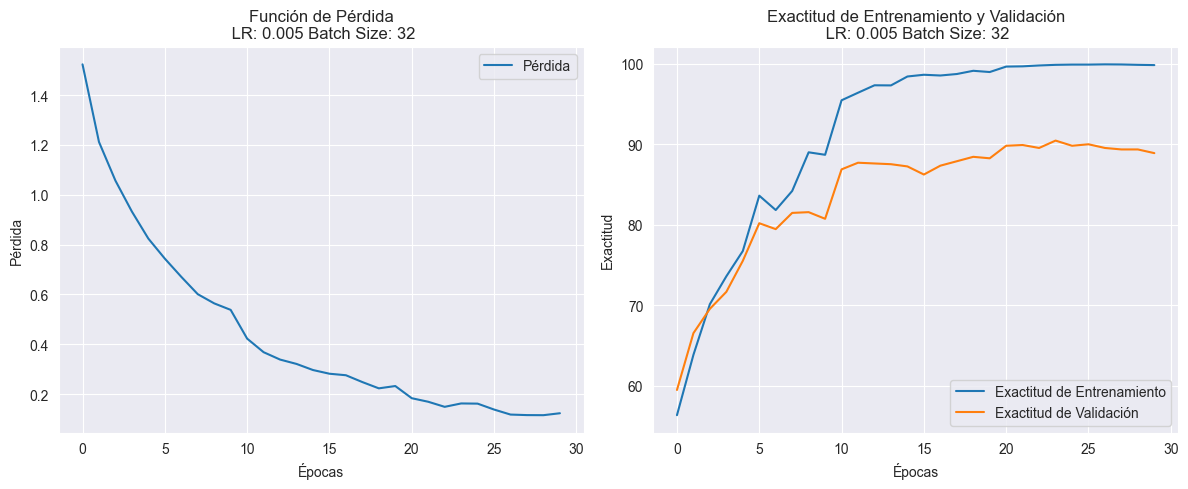


Entrenando con lr=0.005, batch_size=64, epochs=15
    Época 1, pérdida: 1.5158, exactitud entrenamiento: 33.19%, exactitud validación: 34.50%
Learning rate actual: 0.005000
    Época 2, pérdida: 1.1653, exactitud entrenamiento: 64.00%, exactitud validación: 65.41%
Learning rate actual: 0.005000
    Época 3, pérdida: 0.9853, exactitud entrenamiento: 49.41%, exactitud validación: 54.22%
Learning rate actual: 0.005000
    Época 4, pérdida: 0.8547, exactitud entrenamiento: 73.41%, exactitud validación: 71.28%
Learning rate actual: 0.005000
    Época 5, pérdida: 0.7766, exactitud entrenamiento: 79.05%, exactitud validación: 77.61%
Learning rate actual: 0.005000
    Época 6, pérdida: 0.6833, exactitud entrenamiento: 85.24%, exactitud validación: 79.17%
Learning rate actual: 0.005000
    Época 7, pérdida: 0.6083, exactitud entrenamiento: 88.54%, exactitud validación: 82.94%
Learning rate actual: 0.005000
    Época 8, pérdida: 0.5442, exactitud entrenamiento: 90.31%, exactitud validación: 83.

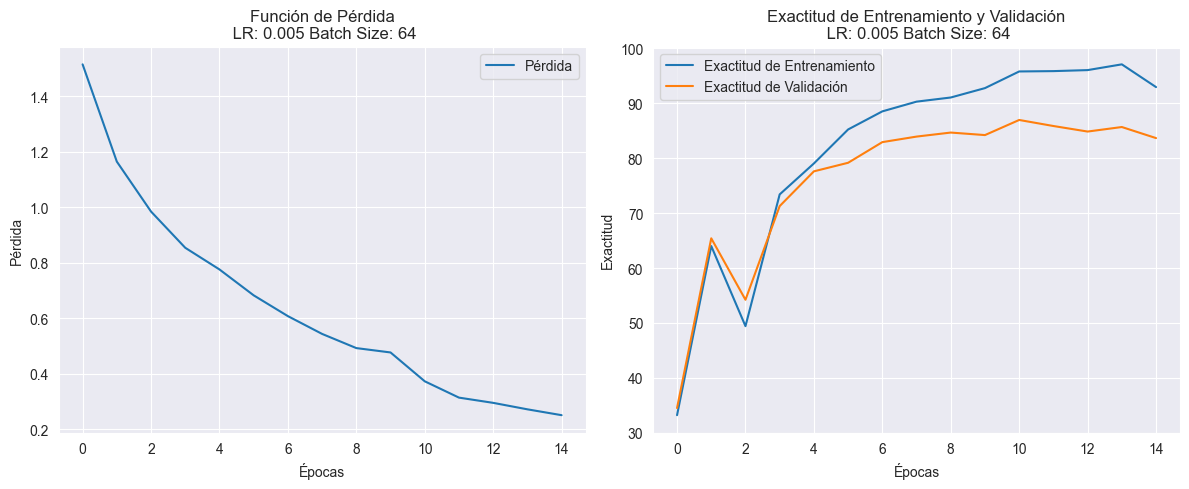


Entrenando con lr=0.005, batch_size=64, epochs=30
    Época 1, pérdida: 1.5148, exactitud entrenamiento: 17.91%, exactitud validación: 19.54%
Learning rate actual: 0.005000
    Época 2, pérdida: 1.1480, exactitud entrenamiento: 65.36%, exactitud validación: 66.70%
Learning rate actual: 0.005000
    Época 3, pérdida: 0.9658, exactitud entrenamiento: 69.69%, exactitud validación: 70.64%
Learning rate actual: 0.005000
    Época 4, pérdida: 0.8175, exactitud entrenamiento: 74.28%, exactitud validación: 72.20%
Learning rate actual: 0.005000
    Época 5, pérdida: 0.7045, exactitud entrenamiento: 82.05%, exactitud validación: 77.34%
Learning rate actual: 0.005000
    Época 6, pérdida: 0.6280, exactitud entrenamiento: 80.45%, exactitud validación: 77.43%
Learning rate actual: 0.005000
    Época 7, pérdida: 0.5905, exactitud entrenamiento: 83.44%, exactitud validación: 79.08%
Learning rate actual: 0.005000
    Época 8, pérdida: 0.5226, exactitud entrenamiento: 89.29%, exactitud validación: 84.

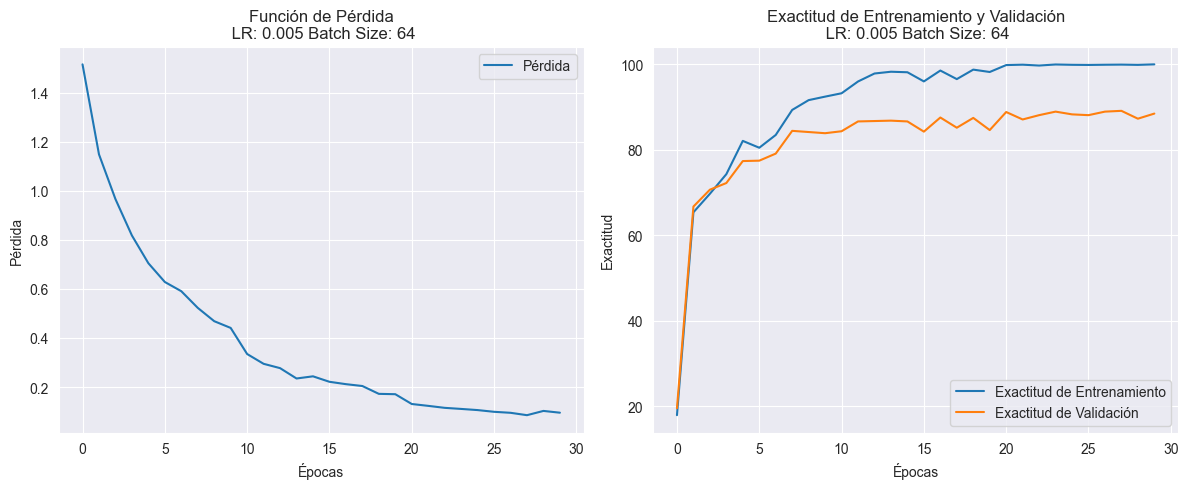


Entrenando con lr=0.001, batch_size=32, epochs=15
    Época 1, pérdida: 1.4749, exactitud entrenamiento: 39.85%, exactitud validación: 38.44%
Learning rate actual: 0.001000
    Época 2, pérdida: 1.0806, exactitud entrenamiento: 43.36%, exactitud validación: 44.22%
Learning rate actual: 0.001000
    Época 3, pérdida: 0.9156, exactitud entrenamiento: 72.01%, exactitud validación: 71.19%
Learning rate actual: 0.001000
    Época 4, pérdida: 0.8055, exactitud entrenamiento: 31.04%, exactitud validación: 30.28%
Learning rate actual: 0.001000
    Época 5, pérdida: 0.6977, exactitud entrenamiento: 81.79%, exactitud validación: 77.89%
Learning rate actual: 0.001000
    Época 6, pérdida: 0.6463, exactitud entrenamiento: 83.89%, exactitud validación: 80.46%
Learning rate actual: 0.001000
    Época 7, pérdida: 0.5900, exactitud entrenamiento: 79.53%, exactitud validación: 76.42%
Learning rate actual: 0.001000
    Época 8, pérdida: 0.5392, exactitud entrenamiento: 88.74%, exactitud validación: 84.

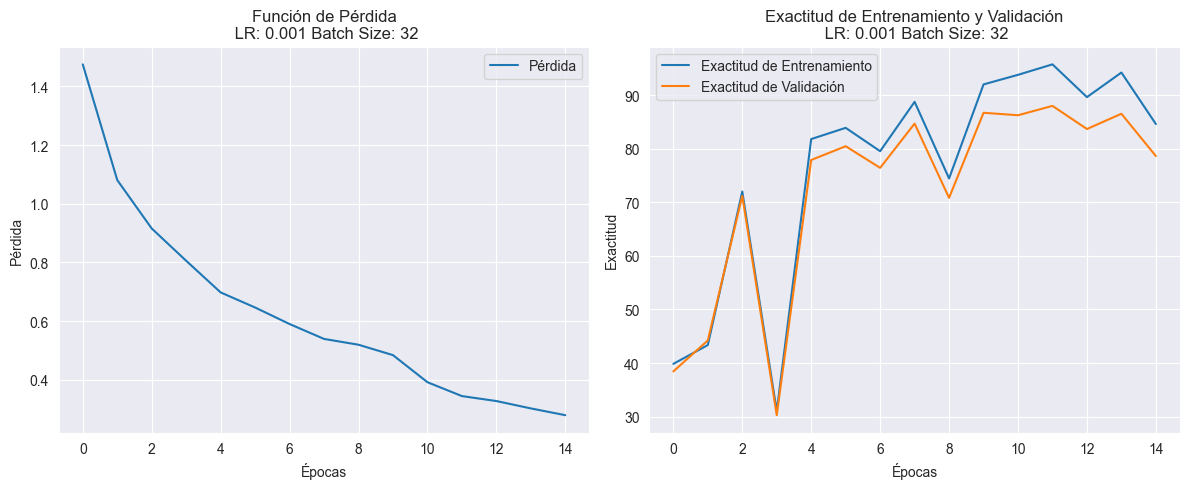


Entrenando con lr=0.001, batch_size=32, epochs=30
    Época 1, pérdida: 1.4764, exactitud entrenamiento: 54.21%, exactitud validación: 54.04%
Learning rate actual: 0.001000
    Época 2, pérdida: 1.1215, exactitud entrenamiento: 66.61%, exactitud validación: 67.61%
Learning rate actual: 0.001000
    Época 3, pérdida: 0.9554, exactitud entrenamiento: 70.52%, exactitud validación: 67.98%
Learning rate actual: 0.001000
    Época 4, pérdida: 0.8268, exactitud entrenamiento: 80.31%, exactitud validación: 77.25%
Learning rate actual: 0.001000
    Época 5, pérdida: 0.7205, exactitud entrenamiento: 61.68%, exactitud validación: 61.19%
Learning rate actual: 0.001000
    Época 6, pérdida: 0.6537, exactitud entrenamiento: 84.77%, exactitud validación: 80.64%
Learning rate actual: 0.001000
    Época 7, pérdida: 0.6052, exactitud entrenamiento: 81.12%, exactitud validación: 77.25%
Learning rate actual: 0.001000
    Época 8, pérdida: 0.5618, exactitud entrenamiento: 63.72%, exactitud validación: 63.

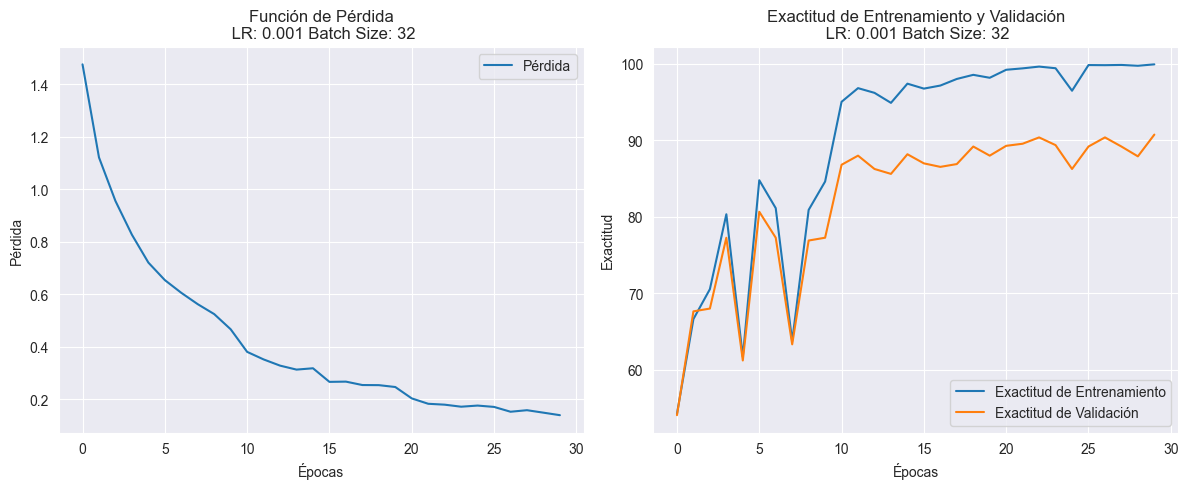


Entrenando con lr=0.001, batch_size=64, epochs=15
    Época 1, pérdida: 1.4744, exactitud entrenamiento: 57.59%, exactitud validación: 58.90%
Learning rate actual: 0.001000
    Época 2, pérdida: 1.0795, exactitud entrenamiento: 58.98%, exactitud validación: 60.46%
Learning rate actual: 0.001000
    Época 3, pérdida: 0.8978, exactitud entrenamiento: 51.31%, exactitud validación: 51.47%
Learning rate actual: 0.001000
    Época 4, pérdida: 0.7867, exactitud entrenamiento: 67.11%, exactitud validación: 65.96%
Learning rate actual: 0.001000
    Época 5, pérdida: 0.6955, exactitud entrenamiento: 60.35%, exactitud validación: 61.01%
Learning rate actual: 0.001000
    Época 6, pérdida: 0.6366, exactitud entrenamiento: 81.22%, exactitud validación: 79.63%
Learning rate actual: 0.001000
    Época 7, pérdida: 0.5813, exactitud entrenamiento: 88.51%, exactitud validación: 82.84%
Learning rate actual: 0.001000
    Época 8, pérdida: 0.5155, exactitud entrenamiento: 72.74%, exactitud validación: 69.

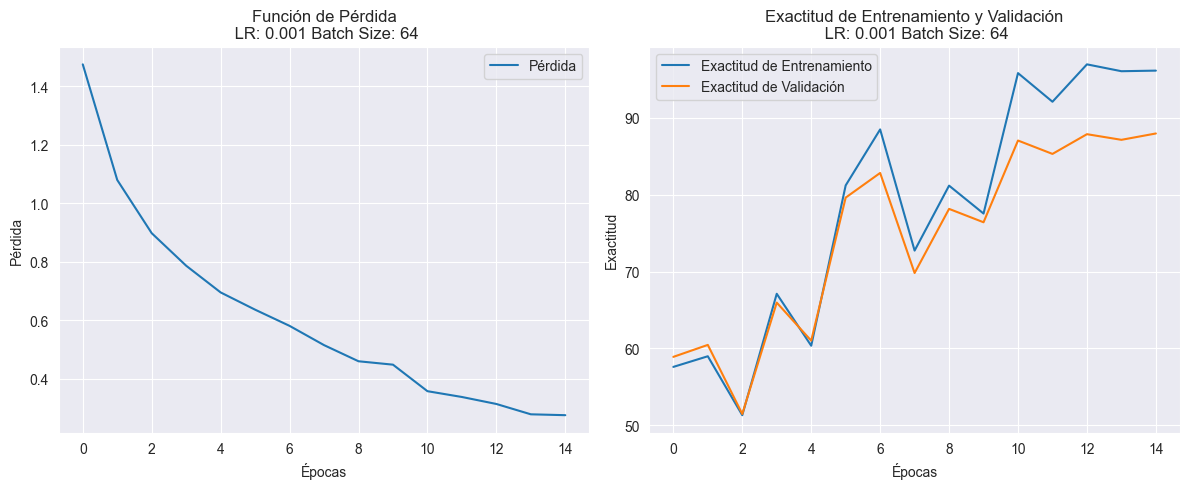


Entrenando con lr=0.001, batch_size=64, epochs=30
    Época 1, pérdida: 1.4906, exactitud entrenamiento: 50.63%, exactitud validación: 51.65%
Learning rate actual: 0.001000
    Época 2, pérdida: 1.0835, exactitud entrenamiento: 66.68%, exactitud validación: 69.27%
Learning rate actual: 0.001000
    Época 3, pérdida: 0.8898, exactitud entrenamiento: 77.28%, exactitud validación: 77.16%
Learning rate actual: 0.001000
    Época 4, pérdida: 0.7630, exactitud entrenamiento: 81.78%, exactitud validación: 80.83%
Learning rate actual: 0.001000
    Época 5, pérdida: 0.6731, exactitud entrenamiento: 72.61%, exactitud validación: 73.03%
Learning rate actual: 0.001000
    Época 6, pérdida: 0.6248, exactitud entrenamiento: 75.12%, exactitud validación: 73.03%
Learning rate actual: 0.001000
    Época 7, pérdida: 0.5436, exactitud entrenamiento: 82.10%, exactitud validación: 78.07%
Learning rate actual: 0.001000
    Época 8, pérdida: 0.4977, exactitud entrenamiento: 80.22%, exactitud validación: 78.

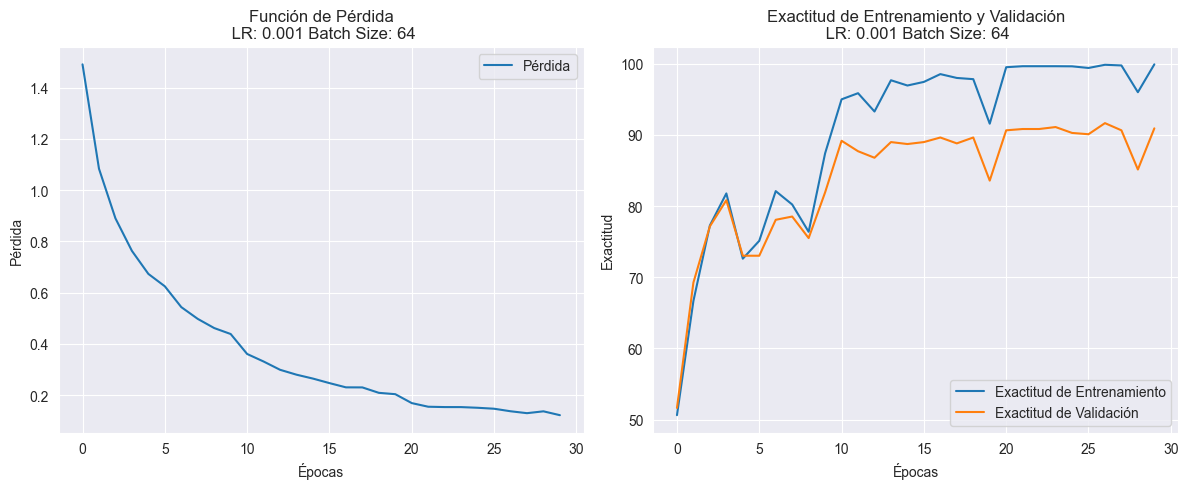


Entrenando con lr=0.0005, batch_size=32, epochs=15
    Época 1, pérdida: 1.5456, exactitud entrenamiento: 51.19%, exactitud validación: 53.39%
Learning rate actual: 0.000500
    Época 2, pérdida: 1.1713, exactitud entrenamiento: 68.13%, exactitud validación: 68.26%
Learning rate actual: 0.000500
    Época 3, pérdida: 0.9813, exactitud entrenamiento: 71.04%, exactitud validación: 72.20%
Learning rate actual: 0.000500
    Época 4, pérdida: 0.8490, exactitud entrenamiento: 62.86%, exactitud validación: 63.39%
Learning rate actual: 0.000500
    Época 5, pérdida: 0.7457, exactitud entrenamiento: 79.47%, exactitud validación: 79.17%
Learning rate actual: 0.000500
    Época 6, pérdida: 0.6826, exactitud entrenamiento: 85.78%, exactitud validación: 82.66%
Learning rate actual: 0.000500
    Época 7, pérdida: 0.6173, exactitud entrenamiento: 75.75%, exactitud validación: 73.39%
Learning rate actual: 0.000500
    Época 8, pérdida: 0.5793, exactitud entrenamiento: 82.35%, exactitud validación: 78

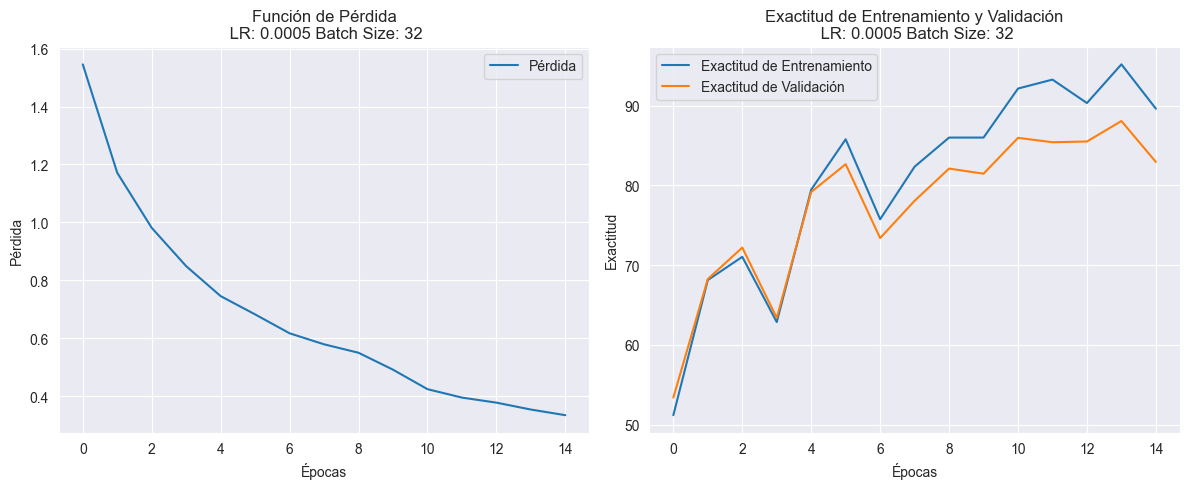


Entrenando con lr=0.0005, batch_size=32, epochs=30
    Época 1, pérdida: 1.5325, exactitud entrenamiento: 52.79%, exactitud validación: 57.16%
Learning rate actual: 0.000500
    Época 2, pérdida: 1.1418, exactitud entrenamiento: 68.48%, exactitud validación: 71.83%
Learning rate actual: 0.000500
    Época 3, pérdida: 0.9843, exactitud entrenamiento: 68.52%, exactitud validación: 71.65%
Learning rate actual: 0.000500
    Época 4, pérdida: 0.8560, exactitud entrenamiento: 74.45%, exactitud validación: 75.87%
Learning rate actual: 0.000500
    Época 5, pérdida: 0.7561, exactitud entrenamiento: 79.84%, exactitud validación: 78.35%
Learning rate actual: 0.000500
    Época 6, pérdida: 0.6896, exactitud entrenamiento: 52.50%, exactitud validación: 53.03%
Learning rate actual: 0.000500
    Época 7, pérdida: 0.6427, exactitud entrenamiento: 69.50%, exactitud validación: 69.08%
Learning rate actual: 0.000500
    Época 8, pérdida: 0.5925, exactitud entrenamiento: 89.31%, exactitud validación: 85

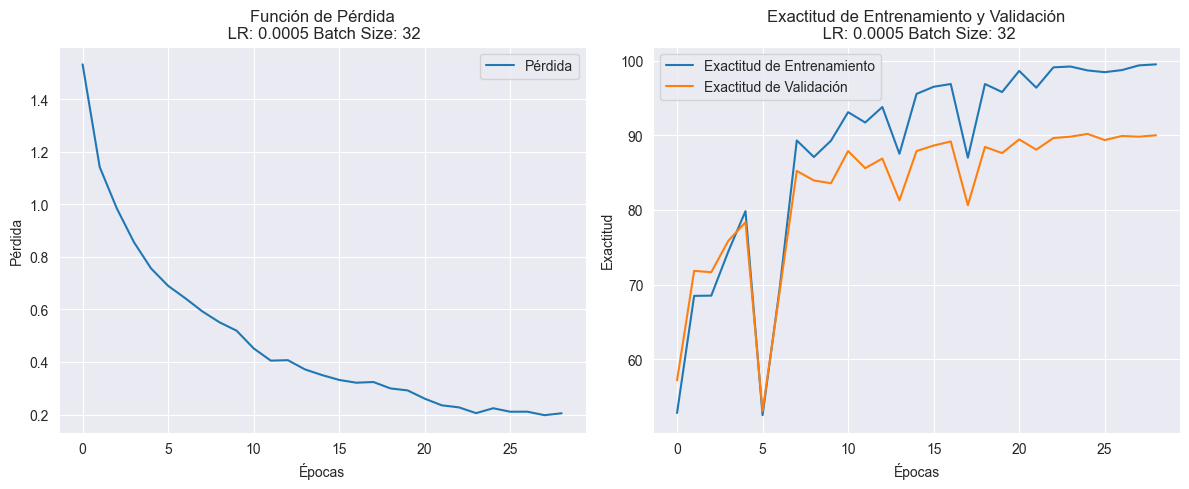


Entrenando con lr=0.0005, batch_size=64, epochs=15
    Época 1, pérdida: 1.5978, exactitud entrenamiento: 33.44%, exactitud validación: 34.31%
Learning rate actual: 0.000500
    Época 2, pérdida: 1.2244, exactitud entrenamiento: 64.08%, exactitud validación: 66.24%
Learning rate actual: 0.000500
    Época 3, pérdida: 1.0013, exactitud entrenamiento: 73.46%, exactitud validación: 74.04%
Learning rate actual: 0.000500
    Época 4, pérdida: 0.8612, exactitud entrenamiento: 65.13%, exactitud validación: 65.69%
Learning rate actual: 0.000500
    Época 5, pérdida: 0.7814, exactitud entrenamiento: 73.66%, exactitud validación: 72.66%
Learning rate actual: 0.000500
    Época 6, pérdida: 0.7081, exactitud entrenamiento: 82.32%, exactitud validación: 79.27%
Learning rate actual: 0.000500
    Época 7, pérdida: 0.6308, exactitud entrenamiento: 79.56%, exactitud validación: 76.97%
Learning rate actual: 0.000500
    Época 8, pérdida: 0.5774, exactitud entrenamiento: 83.67%, exactitud validación: 79

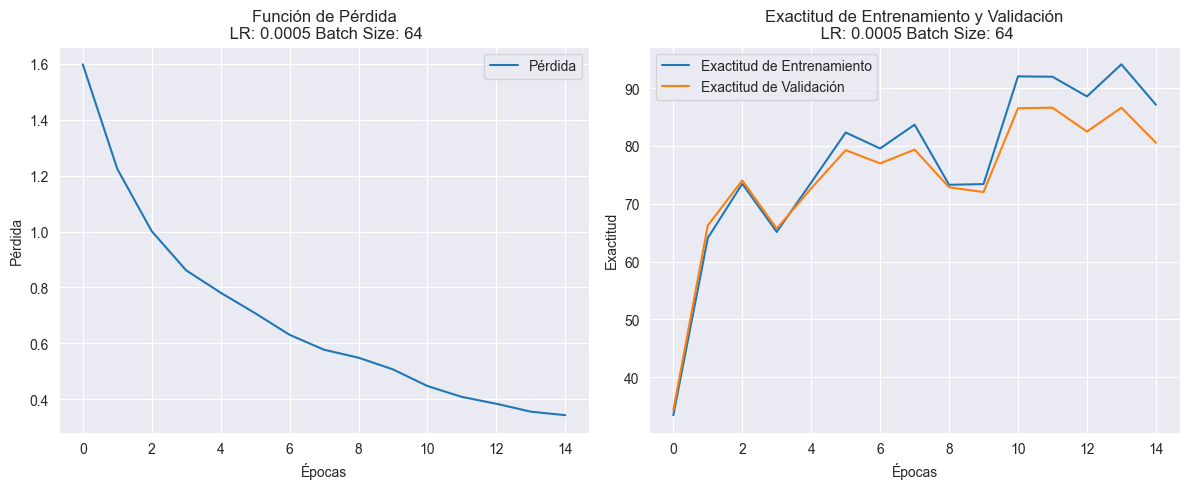


Entrenando con lr=0.0005, batch_size=64, epochs=30
    Época 1, pérdida: 1.5800, exactitud entrenamiento: 29.33%, exactitud validación: 30.73%
Learning rate actual: 0.000500
    Época 2, pérdida: 1.1984, exactitud entrenamiento: 50.89%, exactitud validación: 52.29%
Learning rate actual: 0.000500
    Época 3, pérdida: 1.0152, exactitud entrenamiento: 60.00%, exactitud validación: 63.12%
Learning rate actual: 0.000500
    Época 4, pérdida: 0.8818, exactitud entrenamiento: 70.06%, exactitud validación: 71.28%
Learning rate actual: 0.000500
    Época 5, pérdida: 0.7909, exactitud entrenamiento: 71.77%, exactitud validación: 72.84%
Learning rate actual: 0.000500
    Época 6, pérdida: 0.7174, exactitud entrenamiento: 72.09%, exactitud validación: 74.31%
Learning rate actual: 0.000500
    Época 7, pérdida: 0.6528, exactitud entrenamiento: 80.84%, exactitud validación: 79.72%
Learning rate actual: 0.000500
    Época 8, pérdida: 0.6044, exactitud entrenamiento: 81.92%, exactitud validación: 79

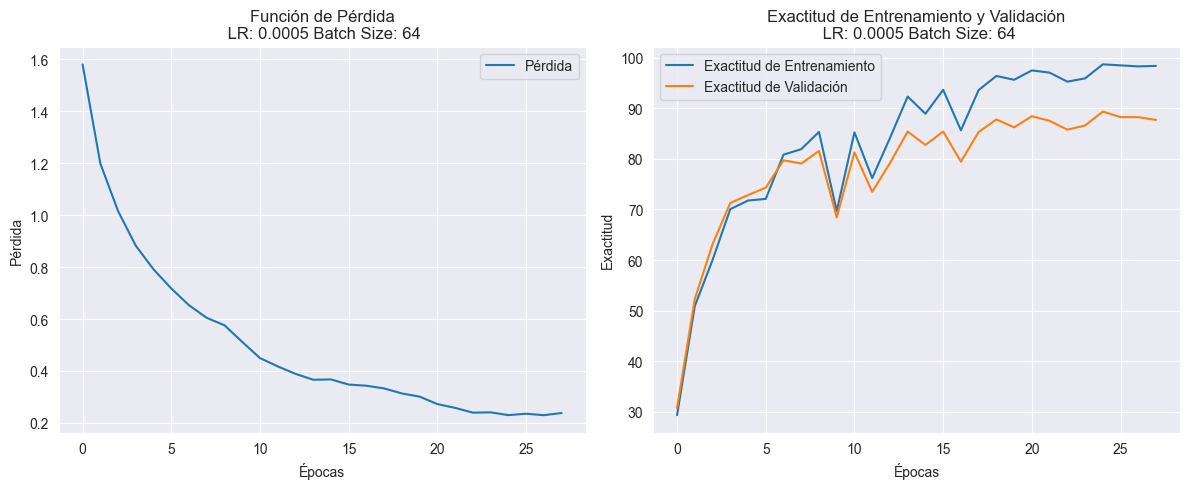


Entrenando con lr=0.0001, batch_size=32, epochs=15
    Época 1, pérdida: 1.7771, exactitud entrenamiento: 18.21%, exactitud validación: 18.53%
Learning rate actual: 0.000100
    Época 2, pérdida: 1.5066, exactitud entrenamiento: 25.51%, exactitud validación: 27.34%
Learning rate actual: 0.000100
    Época 3, pérdida: 1.3433, exactitud entrenamiento: 43.15%, exactitud validación: 42.75%
Learning rate actual: 0.000100
    Época 4, pérdida: 1.2315, exactitud entrenamiento: 57.52%, exactitud validación: 59.27%
Learning rate actual: 0.000100
    Época 5, pérdida: 1.1515, exactitud entrenamiento: 65.99%, exactitud validación: 68.26%
Learning rate actual: 0.000100
    Época 6, pérdida: 1.0722, exactitud entrenamiento: 65.05%, exactitud validación: 68.26%
Learning rate actual: 0.000100
    Época 7, pérdida: 1.0173, exactitud entrenamiento: 66.24%, exactitud validación: 69.63%
Learning rate actual: 0.000100
    Época 8, pérdida: 0.9642, exactitud entrenamiento: 65.73%, exactitud validación: 67

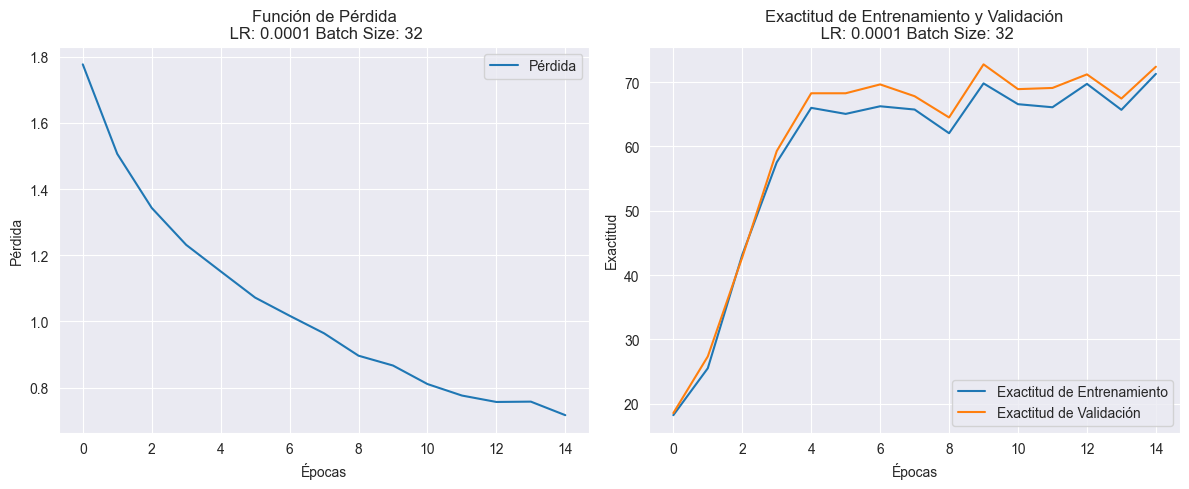


Entrenando con lr=0.0001, batch_size=32, epochs=30
    Época 1, pérdida: 1.7978, exactitud entrenamiento: 17.99%, exactitud validación: 17.16%
Learning rate actual: 0.000100
    Época 2, pérdida: 1.5313, exactitud entrenamiento: 29.27%, exactitud validación: 30.83%
Learning rate actual: 0.000100
    Época 3, pérdida: 1.3606, exactitud entrenamiento: 49.12%, exactitud validación: 50.55%
Learning rate actual: 0.000100
    Época 4, pérdida: 1.2320, exactitud entrenamiento: 55.07%, exactitud validación: 57.52%
Learning rate actual: 0.000100
    Época 5, pérdida: 1.1516, exactitud entrenamiento: 60.21%, exactitud validación: 63.76%
Learning rate actual: 0.000100
    Época 6, pérdida: 1.0701, exactitud entrenamiento: 54.88%, exactitud validación: 58.17%
Learning rate actual: 0.000100
    Época 7, pérdida: 1.0126, exactitud entrenamiento: 47.12%, exactitud validación: 48.17%
Learning rate actual: 0.000100
    Época 8, pérdida: 0.9281, exactitud entrenamiento: 57.09%, exactitud validación: 59

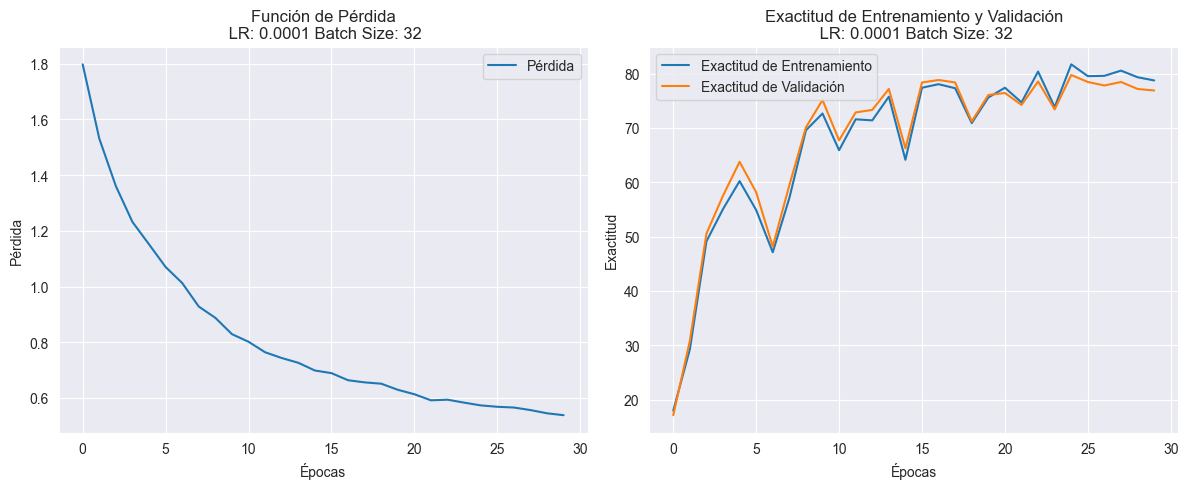


Entrenando con lr=0.0001, batch_size=64, epochs=15
    Época 1, pérdida: 1.8338, exactitud entrenamiento: 25.45%, exactitud validación: 27.98%
Learning rate actual: 0.000100
    Época 2, pérdida: 1.5996, exactitud entrenamiento: 32.44%, exactitud validación: 35.23%
Learning rate actual: 0.000100
    Época 3, pérdida: 1.4446, exactitud entrenamiento: 33.93%, exactitud validación: 34.68%
Learning rate actual: 0.000100
    Época 4, pérdida: 1.3381, exactitud entrenamiento: 48.92%, exactitud validación: 50.73%
Learning rate actual: 0.000100
    Época 5, pérdida: 1.2535, exactitud entrenamiento: 55.33%, exactitud validación: 57.16%
Learning rate actual: 0.000100
    Época 6, pérdida: 1.1751, exactitud entrenamiento: 48.84%, exactitud validación: 51.65%
Learning rate actual: 0.000100
    Época 7, pérdida: 1.1183, exactitud entrenamiento: 58.81%, exactitud validación: 63.76%
Learning rate actual: 0.000100
    Época 8, pérdida: 1.0554, exactitud entrenamiento: 57.61%, exactitud validación: 62

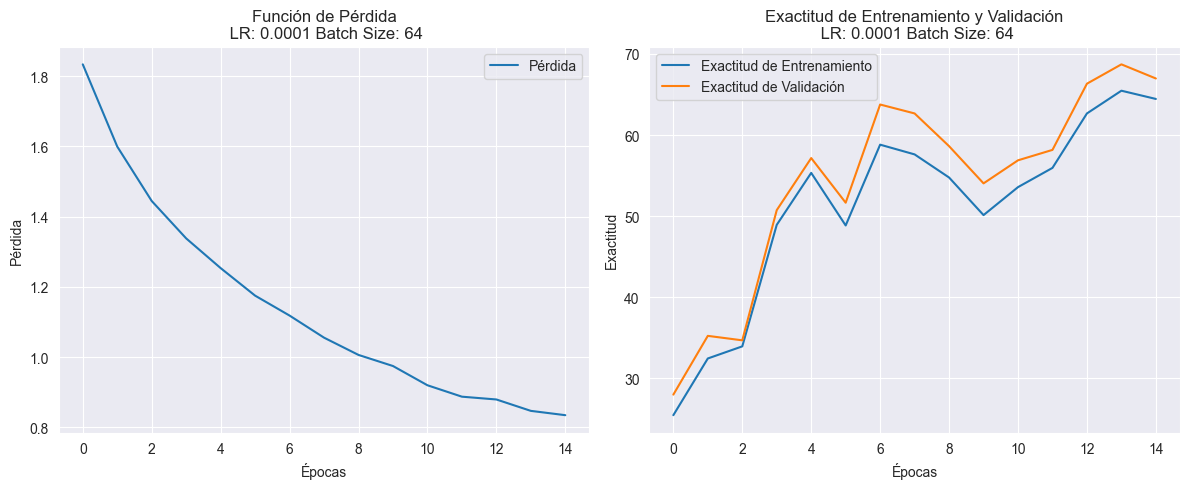


Entrenando con lr=0.0001, batch_size=64, epochs=30
    Época 1, pérdida: 1.8238, exactitud entrenamiento: 14.16%, exactitud validación: 13.94%
Learning rate actual: 0.000100
    Época 2, pérdida: 1.5798, exactitud entrenamiento: 24.82%, exactitud validación: 26.33%
Learning rate actual: 0.000100
    Época 3, pérdida: 1.4377, exactitud entrenamiento: 31.13%, exactitud validación: 31.56%
Learning rate actual: 0.000100
    Época 4, pérdida: 1.3200, exactitud entrenamiento: 36.34%, exactitud validación: 37.43%
Learning rate actual: 0.000100
    Época 5, pérdida: 1.2278, exactitud entrenamiento: 39.03%, exactitud validación: 41.38%
Learning rate actual: 0.000100
    Época 6, pérdida: 1.1609, exactitud entrenamiento: 42.45%, exactitud validación: 44.04%
Learning rate actual: 0.000100
    Época 7, pérdida: 1.1015, exactitud entrenamiento: 43.82%, exactitud validación: 44.68%
Learning rate actual: 0.000100
    Época 8, pérdida: 1.0202, exactitud entrenamiento: 40.51%, exactitud validación: 40

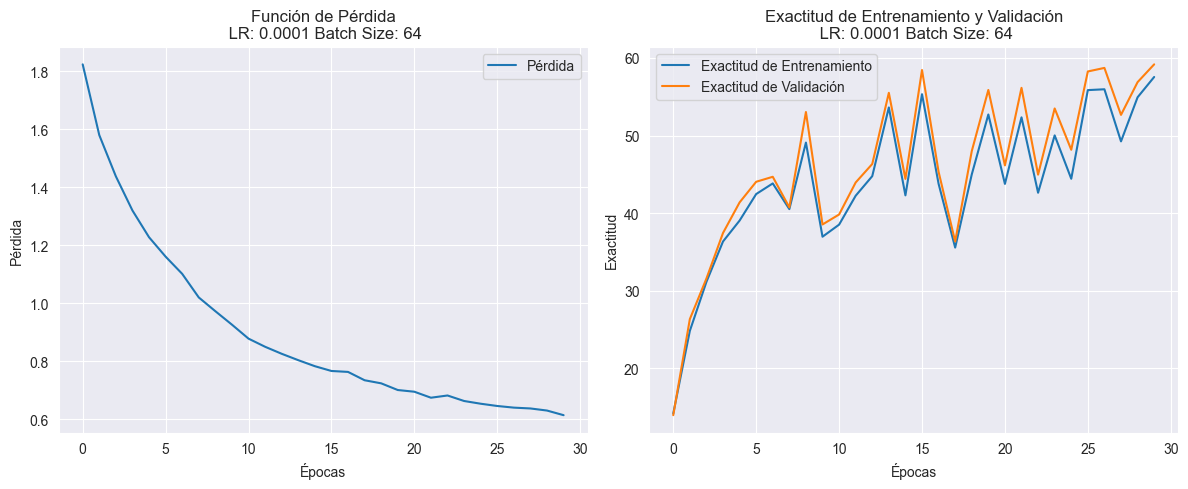


Entrenando con lr=5e-05, batch_size=32, epochs=15
    Época 1, pérdida: 1.8519, exactitud entrenamiento: 15.11%, exactitud validación: 15.60%
Learning rate actual: 0.000050
    Época 2, pérdida: 1.6522, exactitud entrenamiento: 17.76%, exactitud validación: 17.80%
Learning rate actual: 0.000050
    Época 3, pérdida: 1.5143, exactitud entrenamiento: 28.14%, exactitud validación: 29.36%
Learning rate actual: 0.000050
    Época 4, pérdida: 1.4209, exactitud entrenamiento: 32.59%, exactitud validación: 35.41%
Learning rate actual: 0.000050
    Época 5, pérdida: 1.3422, exactitud entrenamiento: 36.57%, exactitud validación: 39.27%
Learning rate actual: 0.000050
    Época 6, pérdida: 1.2725, exactitud entrenamiento: 46.87%, exactitud validación: 49.54%
Learning rate actual: 0.000050
    Época 7, pérdida: 1.2105, exactitud entrenamiento: 51.74%, exactitud validación: 54.68%
Learning rate actual: 0.000050
    Época 8, pérdida: 1.1452, exactitud entrenamiento: 43.92%, exactitud validación: 45.

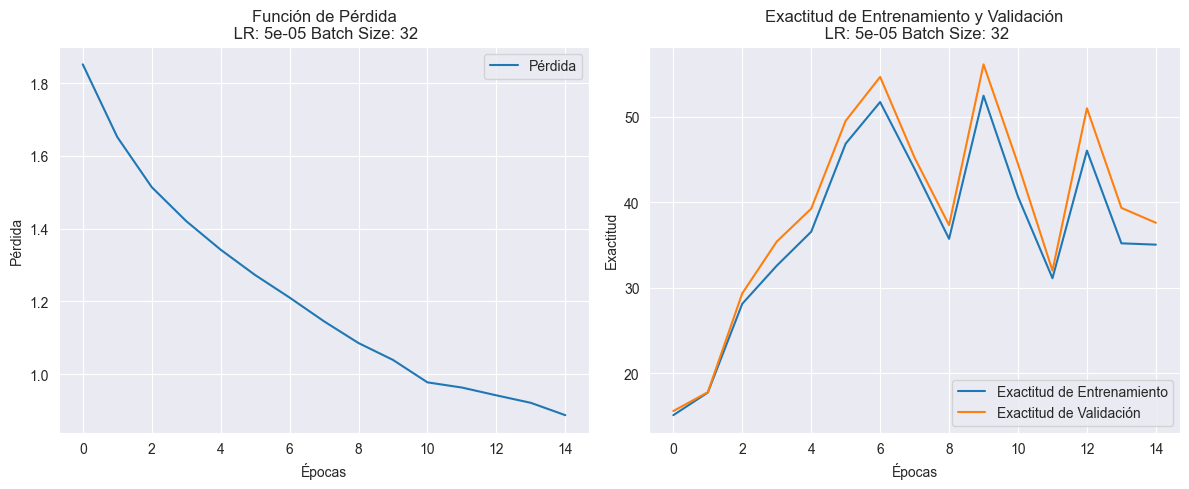


Entrenando con lr=5e-05, batch_size=32, epochs=30
    Época 1, pérdida: 1.8843, exactitud entrenamiento: 19.12%, exactitud validación: 18.35%
Learning rate actual: 0.000050
    Época 2, pérdida: 1.7000, exactitud entrenamiento: 25.48%, exactitud validación: 25.69%
Learning rate actual: 0.000050
    Época 3, pérdida: 1.5680, exactitud entrenamiento: 29.13%, exactitud validación: 31.01%
Learning rate actual: 0.000050
    Época 4, pérdida: 1.4466, exactitud entrenamiento: 29.67%, exactitud validación: 31.65%
Learning rate actual: 0.000050
    Época 5, pérdida: 1.3456, exactitud entrenamiento: 33.72%, exactitud validación: 36.24%
Learning rate actual: 0.000050
    Época 6, pérdida: 1.2899, exactitud entrenamiento: 36.40%, exactitud validación: 37.52%
Learning rate actual: 0.000050
    Época 7, pérdida: 1.2126, exactitud entrenamiento: 40.85%, exactitud validación: 43.03%
Learning rate actual: 0.000050
    Época 8, pérdida: 1.1576, exactitud entrenamiento: 43.59%, exactitud validación: 45.

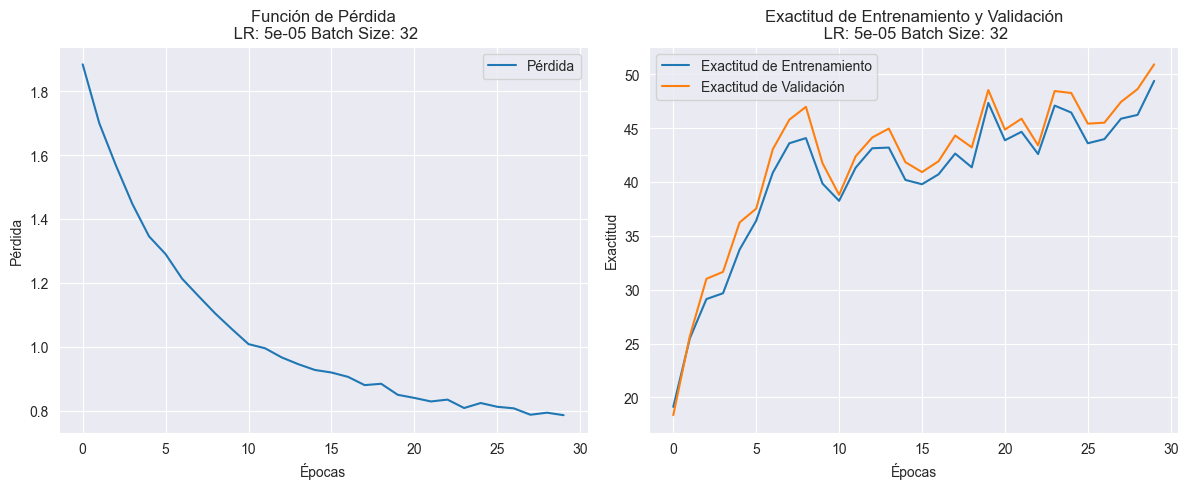


Entrenando con lr=5e-05, batch_size=64, epochs=15
    Época 1, pérdida: 1.8867, exactitud entrenamiento: 15.10%, exactitud validación: 14.86%
Learning rate actual: 0.000050
    Época 2, pérdida: 1.7035, exactitud entrenamiento: 15.56%, exactitud validación: 15.60%
Learning rate actual: 0.000050
    Época 3, pérdida: 1.6028, exactitud entrenamiento: 18.33%, exactitud validación: 18.81%
Learning rate actual: 0.000050
    Época 4, pérdida: 1.4846, exactitud entrenamiento: 22.07%, exactitud validación: 23.58%
Learning rate actual: 0.000050
    Época 5, pérdida: 1.4083, exactitud entrenamiento: 28.37%, exactitud validación: 32.02%
Learning rate actual: 0.000050
    Época 6, pérdida: 1.3356, exactitud entrenamiento: 33.18%, exactitud validación: 35.60%
Learning rate actual: 0.000050
    Época 7, pérdida: 1.2807, exactitud entrenamiento: 39.26%, exactitud validación: 41.10%
Learning rate actual: 0.000050
    Época 8, pérdida: 1.2508, exactitud entrenamiento: 41.85%, exactitud validación: 43.

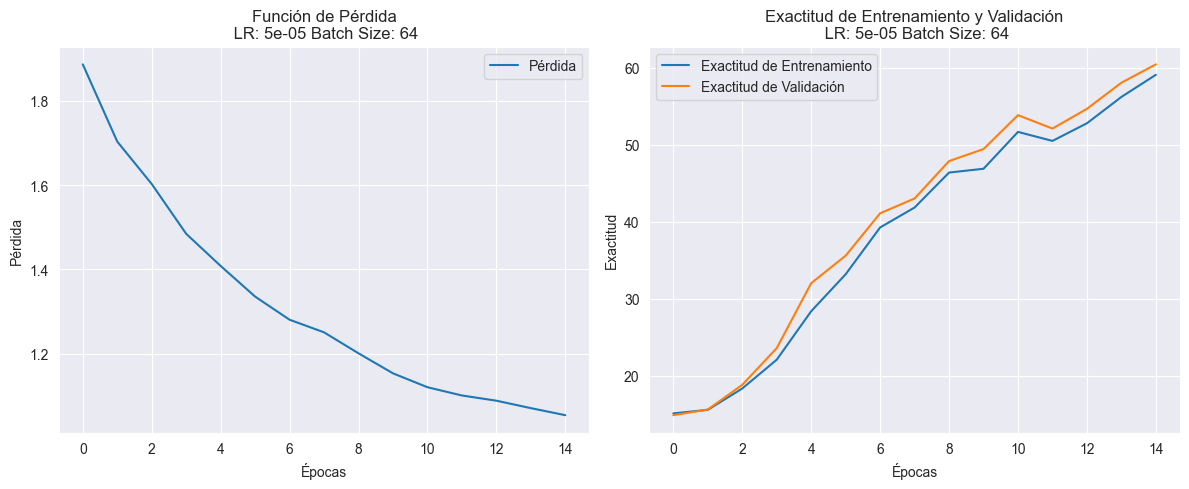


Entrenando con lr=5e-05, batch_size=64, epochs=30
    Época 1, pérdida: 1.9676, exactitud entrenamiento: 17.99%, exactitud validación: 18.17%
Learning rate actual: 0.000050
    Época 2, pérdida: 1.7774, exactitud entrenamiento: 20.16%, exactitud validación: 21.19%
Learning rate actual: 0.000050
    Época 3, pérdida: 1.6878, exactitud entrenamiento: 21.15%, exactitud validación: 22.20%
Learning rate actual: 0.000050
    Época 4, pérdida: 1.6012, exactitud entrenamiento: 26.25%, exactitud validación: 28.17%
Learning rate actual: 0.000050
    Época 5, pérdida: 1.5174, exactitud entrenamiento: 34.06%, exactitud validación: 34.59%
Learning rate actual: 0.000050
    Época 6, pérdida: 1.4364, exactitud entrenamiento: 40.39%, exactitud validación: 41.74%
Learning rate actual: 0.000050
    Época 7, pérdida: 1.3764, exactitud entrenamiento: 41.40%, exactitud validación: 41.74%
Learning rate actual: 0.000050
    Época 8, pérdida: 1.3129, exactitud entrenamiento: 50.39%, exactitud validación: 53.

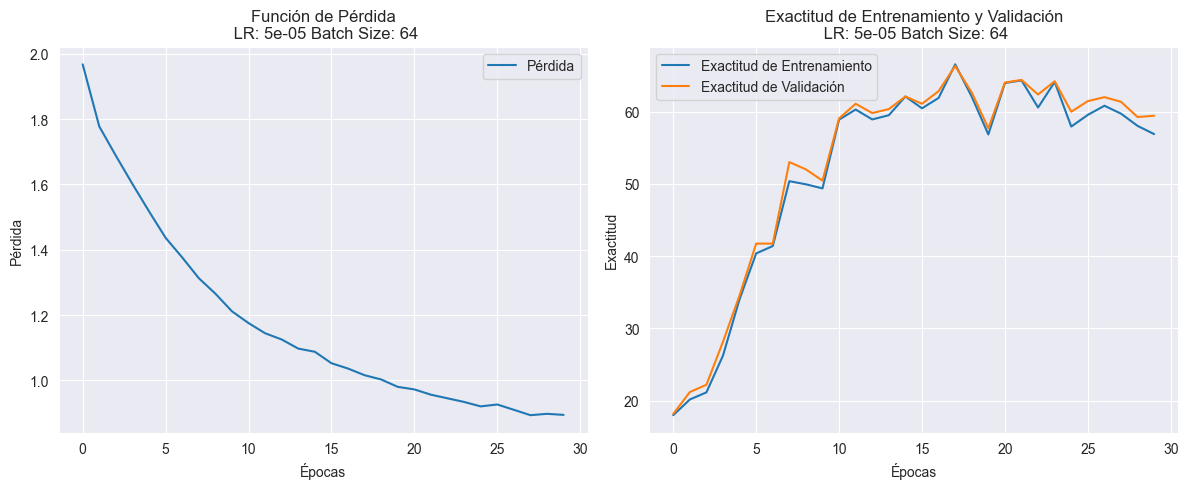


Entrenando con lr=1e-05, batch_size=32, epochs=15
    Época 1, pérdida: 2.0378, exactitud entrenamiento: 14.54%, exactitud validación: 14.31%
Learning rate actual: 0.000010
    Época 2, pérdida: 1.9365, exactitud entrenamiento: 16.28%, exactitud validación: 17.71%
Learning rate actual: 0.000010
    Época 3, pérdida: 1.8515, exactitud entrenamiento: 18.96%, exactitud validación: 20.64%
Learning rate actual: 0.000010
    Época 4, pérdida: 1.7987, exactitud entrenamiento: 19.45%, exactitud validación: 20.64%
Learning rate actual: 0.000010
    Época 5, pérdida: 1.7521, exactitud entrenamiento: 18.15%, exactitud validación: 18.99%
Learning rate actual: 0.000010
    Época 6, pérdida: 1.7146, exactitud entrenamiento: 18.93%, exactitud validación: 19.27%
Learning rate actual: 0.000010
    Época 7, pérdida: 1.6910, exactitud entrenamiento: 20.18%, exactitud validación: 20.18%
Learning rate actual: 0.000010
    Época 8, pérdida: 1.6429, exactitud entrenamiento: 22.07%, exactitud validación: 22.

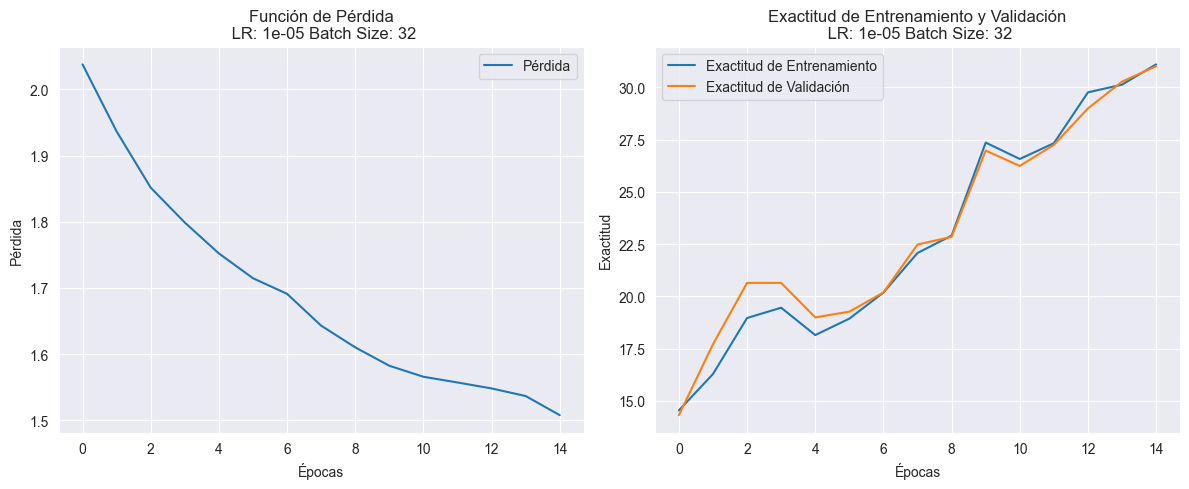


Entrenando con lr=1e-05, batch_size=32, epochs=30
    Época 1, pérdida: 2.0393, exactitud entrenamiento: 13.97%, exactitud validación: 14.04%
Learning rate actual: 0.000010
    Época 2, pérdida: 1.9180, exactitud entrenamiento: 14.46%, exactitud validación: 14.31%
Learning rate actual: 0.000010
    Época 3, pérdida: 1.8388, exactitud entrenamiento: 15.77%, exactitud validación: 15.69%
Learning rate actual: 0.000010
    Época 4, pérdida: 1.7812, exactitud entrenamiento: 18.19%, exactitud validación: 17.71%
Learning rate actual: 0.000010
    Época 5, pérdida: 1.7338, exactitud entrenamiento: 19.05%, exactitud validación: 18.81%
Learning rate actual: 0.000010
    Época 6, pérdida: 1.6926, exactitud entrenamiento: 21.67%, exactitud validación: 21.19%
Learning rate actual: 0.000010
    Época 7, pérdida: 1.6611, exactitud entrenamiento: 23.98%, exactitud validación: 24.04%
Learning rate actual: 0.000010
    Época 8, pérdida: 1.6289, exactitud entrenamiento: 25.11%, exactitud validación: 26.

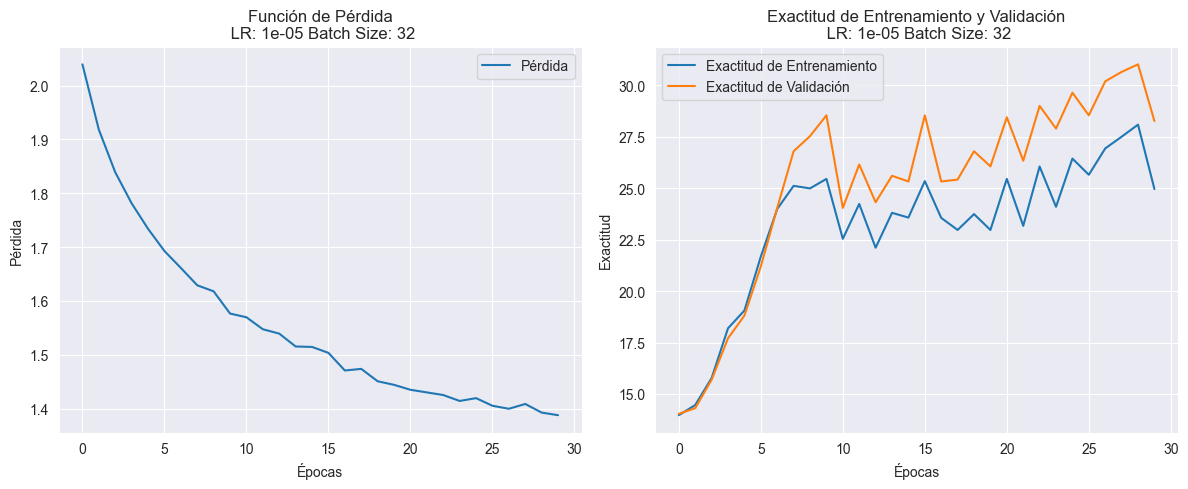


Entrenando con lr=1e-05, batch_size=64, epochs=15
    Época 1, pérdida: 2.0846, exactitud entrenamiento: 14.79%, exactitud validación: 14.40%
Learning rate actual: 0.000010
    Época 2, pérdida: 2.0007, exactitud entrenamiento: 17.56%, exactitud validación: 17.06%
Learning rate actual: 0.000010
    Época 3, pérdida: 1.9530, exactitud entrenamiento: 19.95%, exactitud validación: 20.46%
Learning rate actual: 0.000010
    Época 4, pérdida: 1.8959, exactitud entrenamiento: 20.83%, exactitud validación: 21.65%
Learning rate actual: 0.000010
    Época 5, pérdida: 1.8405, exactitud entrenamiento: 21.43%, exactitud validación: 21.38%
Learning rate actual: 0.000010
    Época 6, pérdida: 1.8110, exactitud entrenamiento: 23.57%, exactitud validación: 23.85%
Learning rate actual: 0.000010
    Época 7, pérdida: 1.7577, exactitud entrenamiento: 24.28%, exactitud validación: 24.59%
Learning rate actual: 0.000010
    Época 8, pérdida: 1.7245, exactitud entrenamiento: 28.28%, exactitud validación: 27.

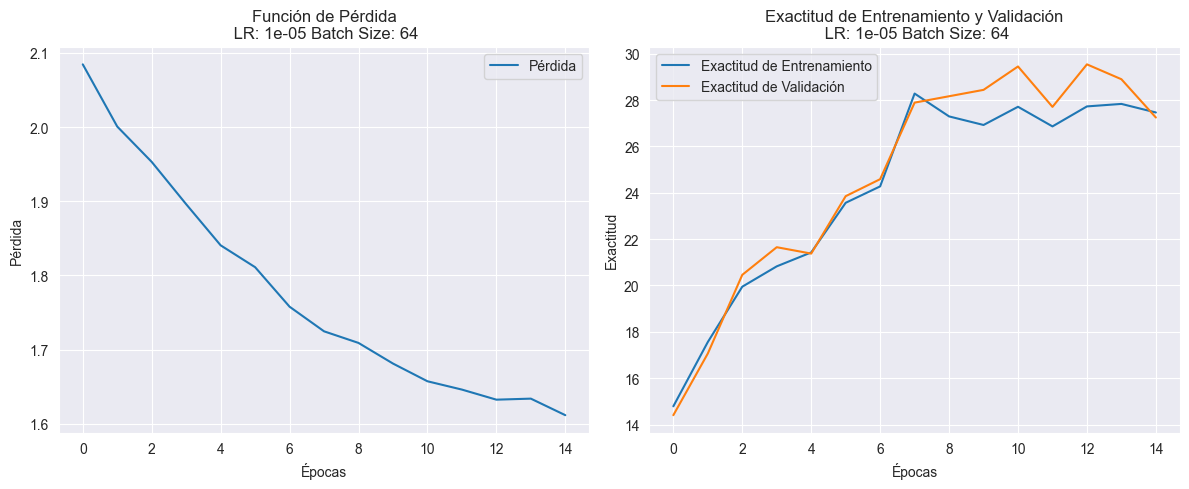


Entrenando con lr=1e-05, batch_size=64, epochs=30
    Época 1, pérdida: 2.0181, exactitud entrenamiento: 14.33%, exactitud validación: 14.04%
Learning rate actual: 0.000010
    Época 2, pérdida: 1.9292, exactitud entrenamiento: 14.14%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 3, pérdida: 1.8624, exactitud entrenamiento: 14.08%, exactitud validación: 13.94%
Learning rate actual: 0.000010
    Época 4, pérdida: 1.8165, exactitud entrenamiento: 14.14%, exactitud validación: 14.04%
Learning rate actual: 0.000010
    Época 5, pérdida: 1.7894, exactitud entrenamiento: 14.36%, exactitud validación: 14.22%
Learning rate actual: 0.000010
    Época 6, pérdida: 1.7515, exactitud entrenamiento: 14.42%, exactitud validación: 14.22%
Learning rate actual: 0.000010
    Época 7, pérdida: 1.7219, exactitud entrenamiento: 14.90%, exactitud validación: 14.68%
Learning rate actual: 0.000010
    Época 8, pérdida: 1.7078, exactitud entrenamiento: 15.90%, exactitud validación: 15.

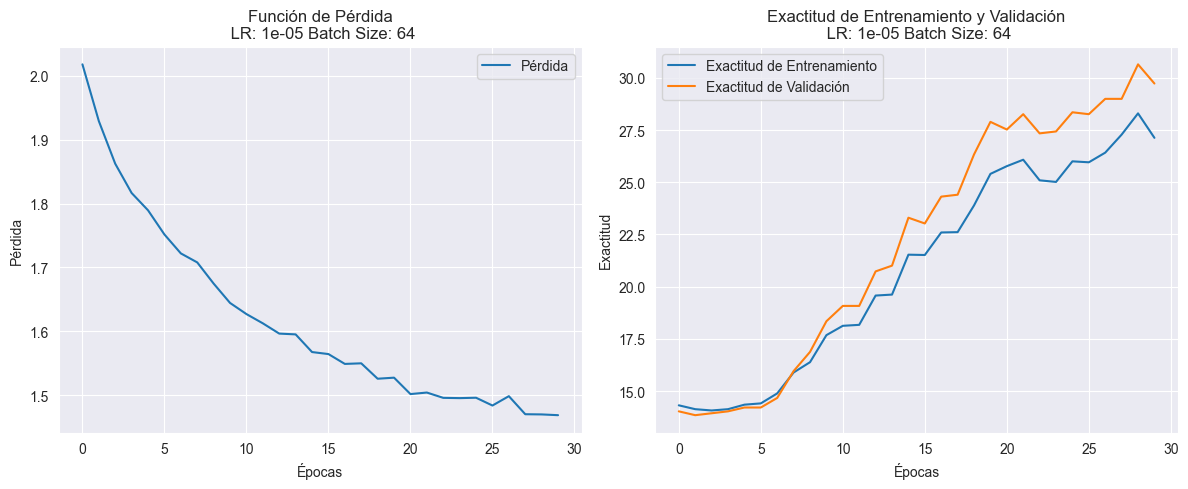

In [8]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from itertools import product

learning_rates = [0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
batch_sizes = [32, 64]
epochs_list = [15, 30]

resultados = []
modelos = {}

for lr, batch_size, epochs in product(learning_rates, batch_sizes, epochs_list):

    # Crear DataLoaders para los datos de entrenamiento, validación y test
    dataloader_entrenamiento = DataLoader(dataset_entrenamiento, batch_size=batch_size, shuffle=True)
    dataloader_validacion = DataLoader(dataset_validacion, batch_size=batch_size, shuffle=False)
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    modelo = ConvNet().to(device)
    criterio = nn.CrossEntropyLoss()
    optimizador = optim.Adam(modelo.parameters(), lr=lr)
    scheduler = StepLR(optimizador, step_size=10, gamma=0.5)

    combinacion = (lr, batch_size, epochs)
    print(f"\nEntrenando con lr={lr}, batch_size={batch_size}, epochs={epochs}")

    modelos[combinacion] = modelo

    valores_perdida = []
    exactitud_entrenamiento = []
    exactitud_validacion = []

    early_stopping = EarlyStopping(patience=5, delta=0.01)

    for epoca in range(epochs):
        modelos[combinacion].train()
        running_loss = 0.0
        for images, labels in dataloader_entrenamiento:
            images, labels = images.to(device), labels.to(device)
            outputs = modelos[combinacion](images)
            loss = criterio(outputs, labels)
            loss.backward()
            optimizador.step()
            optimizador.zero_grad()
            running_loss += loss.item()

        valores_perdida.append(running_loss / len(dataloader_entrenamiento))

        with torch.no_grad():
            modelos[combinacion].eval()

            # Calcular exactitud de entrenamiento
            correctas = 0
            total = 0
            for images, labels in dataloader_entrenamiento:
                images, labels = images.to(device), labels.to(device)
                outputs = modelos[combinacion](images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correctas += (predicted == labels).sum().item()
            exactitud_entrenamiento.append(100 * correctas / total)

            # Calcular exactitud de validación
            correctas = 0
            total = 0
            for images, labels in dataloader_validacion:
                images, labels = images.to(device), labels.to(device)
                outputs = modelos[combinacion](images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correctas += (predicted == labels).sum().item()
            exactitud_validacion.append(100 * correctas / total)
        
        scheduler.step()
        
        # Early stopping
        val_loss = valores_perdida[-1]  # Usamos la pérdida más reciente
        early_stopping(val_loss, modelo)

        # Verifica si se activa la parada anticipada
        if early_stopping.early_stop:
            print("Parada anticipada activada")
            modelo.load_state_dict(early_stopping.best_model_wts)  # Cargar los mejores pesos
            break

        # Imprimir métricas de la época
        print(f'    Época {epoca+1}, pérdida: {val_loss:.4f}, exactitud entrenamiento: {exactitud_entrenamiento[-1]:.2f}%, exactitud validación: {exactitud_validacion[-1]:.2f}%')
        
        for param_group in optimizador.param_groups:
            print(f"Learning rate actual: {param_group['lr']:.6f}")

    graficar_perdida_entrenamiento_validacion(lr, batch_size, epochs, valores_perdida, exactitud_entrenamiento, exactitud_validacion)
    resultados.append((lr, batch_size, epochs, exactitud_validacion[-1]))


Top configuraciones:
    LR=0.001, Batch=64, Epochs=30, Exactitud validación=90.92%
    LR=0.001, Batch=32, Epochs=30, Exactitud validación=90.73%
    LR=0.0005, Batch=32, Epochs=30, Exactitud validación=90.00%
    LR=0.005, Batch=32, Epochs=30, Exactitud validación=88.90%
    LR=0.005, Batch=64, Epochs=30, Exactitud validación=88.44%

Exactitud del modelo en el conjunto de test para el conjunto de hiperprámetros LR=0.001, Batch=64, Epochs=30    : 88.31%
Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.8944    0.8523    0.8729       149
           1     0.9494    0.9868    0.9677       152
           2     0.7888    0.8523    0.8194       149
           3     0.8239    0.8382    0.8309       173
           4     0.9139    0.9200    0.9169       150
           5     0.8652    0.8188    0.8414       149
           6     0.9597    0.9167    0.9377       156

    accuracy                         0.8831      1078
   macro avg     0.8850    

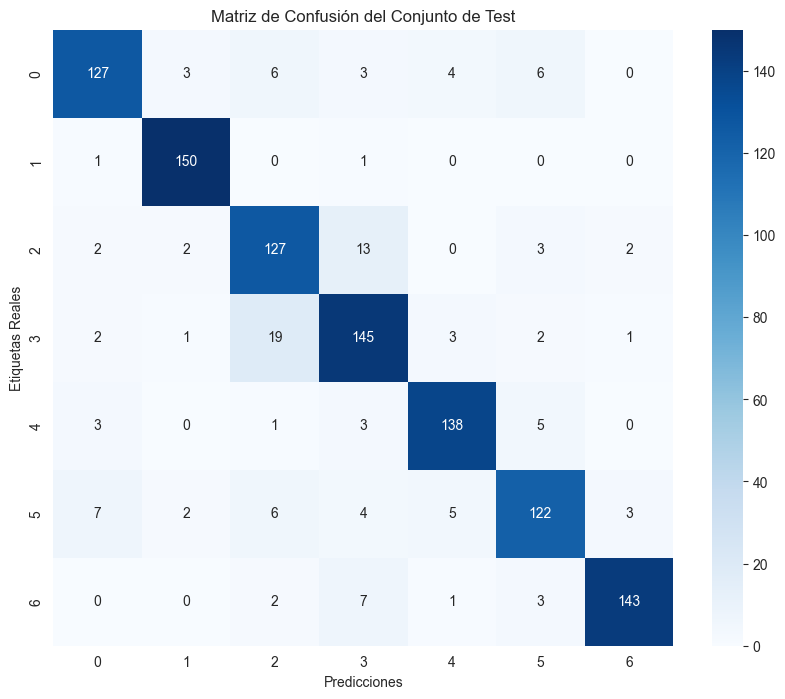

Clases presentes en el conjunto de test: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)}


In [9]:
mejores_resultados = sorted(resultados, key=lambda x: x[3], reverse=True)
print("Top configuraciones:")
for res in mejores_resultados[:5]:
    print(f"    LR={res[0]}, Batch={res[1]}, Epochs={res[2]}, Exactitud validación={res[3]:.2f}%")

mejor = (mejores_resultados[0][0], mejores_resultados[0][1], mejores_resultados[0][2])
modelo = modelos[mejor]
exactitud_test = calcular_exactitud_test(modelo, dataloader_test, device)
print(f"\nExactitud del modelo en el conjunto de test para el conjunto de hiperprámetros LR={mejor[0]}, Batch={mejor[1]}, Epochs={mejor[2]}    : {exactitud_test:.2f}%")
matriz_de_confusion(modelo, dataloader_test, device)

In [3]:
import os
from PIL import Image
from torchvision import transforms
"""
# Transformaciones para augmentación
augmentation1 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
])
augmentation2 = transforms.Compose([
    transforms.RandomRotation(degrees=35),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
])

augmentations = [augmentation1, augmentation2]

for i, augmentation in enumerate(augmentations):

    # Directorios de entrada y salida
    original_dir = '/Users/alejandroalemanaleman/Downloads/AA2 - trabajo 1/train'
    augmented_dir = '/Users/alejandroalemanaleman/Downloads/AA2 - trabajo 1/train_augmented'

    # Crear directorio para imágenes augmentadas si no existe

    os.makedirs(augmented_dir, exist_ok=True)

    # Aplicar augmentación y guardar las imágenes
    for class_name in os.listdir(original_dir):
        class_dir = os.path.join(original_dir, class_name)
        augmented_class_dir = os.path.join(augmented_dir, class_name)
        os.makedirs(augmented_class_dir, exist_ok=True)

        if os.path.isdir(class_dir):
            print(f"Procesando clase: {class_name}")
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                augmented_img_path = os.path.join(augmented_class_dir, f"aug_{i+1}_{img_name}")

                # Abrir la imagen y aplicar transformaciones
                with Image.open(img_path) as img:
                    augmented_img = augmentation(img)
                    augmented_img.save(augmented_img_path)
"""


Procesando clase: barco
Procesando clase: bus
Procesando clase: helicoptero
Procesando clase: coche
Procesando clase: motos
Procesando clase: aviones
Procesando clase: globo
Procesando clase: barco
Procesando clase: bus
Procesando clase: helicoptero
Procesando clase: coche
Procesando clase: motos
Procesando clase: aviones
Procesando clase: globo
